# Lesson 2: Tool Calling

## Setup

In [ ]:
#from helper import get_openai_api_key
#OPENAI_API_KEY = get_openai_api_key()

In [1]:
import nest_asyncio
nest_asyncio.apply()

## 1. Define a Simple Tool

In [6]:
from llama_index.core.tools import FunctionTool

# Define functions.
# Note that comments within functions are important

def add(x: int, y: int) -> int:
    """Adds two integers together."""
    return x + y

def mystery(x: str, y: str) -> int: 
    """Mystery function that operates on top of two numbers."""
    x = int(x)
    y = int(y)
    return (x + y) * (x + y)


add_tool = FunctionTool.from_defaults(fn=add)
mystery_tool = FunctionTool.from_defaults(fn=mystery)

In [37]:
%%time

from llama_index.embeddings.ollama import OllamaEmbedding
from llama_index.llms.openai_like import OpenAILike

llm = OpenAILike(
                          temperature=0.7,
                          model="gpt-3.5-turbo",                      # Can be any name, not necessarily openai's gpt
                          api_base="http://127.0.0.1:8080/v1",
                          api_key="fake",
                          timeout= 120.0,
                          is_chat_model = True,
                          is_function_calling_model=True,
                          )

# Predict which tool to use and then call it
response = llm.predict_and_call(
                                [add_tool, mystery_tool], 
                                "Tell me the output of the mystery function on 2 and 9", 
                                verbose=True
                               )

print(str(response))

/home/ashok/langchain/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


=== Calling Function ===
Calling function: mystery with args: {"x": "2", "y": "9"}
=== Function Output ===
121
121


## 2. Define an Auto-Retrieval Tool

### Load Data

To download this paper, below is the needed code:

#!wget "https://openreview.net/pdf?id=VtmBAGCN7o" -O metagpt.pdf

**Note**: The pdf file is included with this lesson. To access it, go to the `File` menu and select`Open...`.

In [52]:
from llama_index.core import Settings

Settings.llm = OpenAILike(
                          temperature=0.7,
                          model="gpt-3.5-turbo",                      # Can be any name, not necessarily openai's gpt
                          api_base="http://127.0.0.1:8080/v1",
                          api_key="fake",
                          timeout= 120.0,
                          is_chat_model = True,
                          is_function_calling_model=True,
                          )


Settings.embed_model = OllamaEmbedding(
                                        model_name="nomic-embed-text",      # Using foundational model may be overkill
                                        base_url="http://localhost:11434",
                                       )

In [17]:
from llama_index.core import SimpleDirectoryReader
# load documents
documents = SimpleDirectoryReader(input_files=["/home/ashok/Documents/csvrag/metagpt.pdf"]).load_data()

In [39]:
from llama_index.core.node_parser import SentenceSplitter
splitter = SentenceSplitter(chunk_size=1024)
nodes = splitter.get_nodes_from_documents(documents)

In [40]:
print(nodes[0].get_content(metadata_mode="all"))

page_label: 1
file_name: metagpt.pdf
file_path: /home/ashok/Documents/csvrag/metagpt.pdf
file_type: application/pdf
file_size: 16911937
creation_date: 2025-03-20
last_modified_date: 2025-03-20

Preprint
METAGPT: M ETA PROGRAMMING FOR A
MULTI -AGENT COLLABORATIVE FRAMEWORK
Sirui Hong1∗, Mingchen Zhuge2∗, Jonathan Chen1, Xiawu Zheng3, Yuheng Cheng4,
Ceyao Zhang4, Jinlin Wang1, Zili Wang, Steven Ka Shing Yau5, Zijuan Lin4,
Liyang Zhou6, Chenyu Ran1, Lingfeng Xiao1,7, Chenglin Wu1†, J¨urgen Schmidhuber2,8
1DeepWisdom, 2AI Initiative, King Abdullah University of Science and Technology,
3Xiamen University, 4The Chinese University of Hong Kong, Shenzhen,
5Nanjing University, 6University of Pennsylvania,
7University of California, Berkeley, 8The Swiss AI Lab IDSIA/USI/SUPSI
ABSTRACT
Remarkable progress has been made on automated problem solving through so-
cieties of agents based on large language models (LLMs). Existing LLM-based
multi-agent systems can already solve simple dialogue tasks. So

In [41]:
from llama_index.core import VectorStoreIndex

vector_index = VectorStoreIndex(nodes, show_progress = True)
query_engine = vector_index.as_query_engine(similarity_top_k=2)

Generating embeddings: 100%|████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 26.76it/s]


In [42]:
%%time

from llama_index.core.vector_stores import MetadataFilters

query_engine = vector_index.as_query_engine(
    similarity_top_k=2,
    filters=MetadataFilters.from_dicts(
        [
            {"key": "page_label", "value": "2"}
        ]
    )
)

response = query_engine.query(
    "What are some high-level results of MetaGPT?", 
)

In [43]:
print(str(response))

MetaGPT achieves a new state-of-the-art in code generation benchmarks with high scores. It also demonstrates robustness and efficiency, achieving a 100% task completion rate in experimental evaluations. Additionally, it outperforms other popular frameworks for creating complex software projects.


In [44]:
for n in response.source_nodes:
    print(n.metadata)

{'page_label': '2', 'file_name': 'metagpt.pdf', 'file_path': '/home/ashok/Documents/csvrag/metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2025-03-20', 'last_modified_date': '2025-03-20'}


### Define the Auto-Retrieval Tool

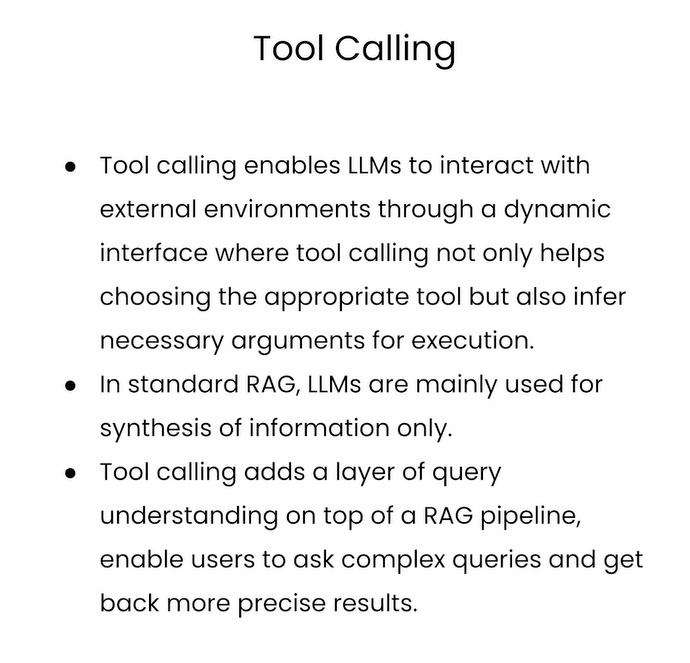

In [53]:
from typing import List
from llama_index.core.vector_stores import FilterCondition


def vector_query(
                 query: str, 
                 page_numbers: List[str]
                ) -> str:
    
    """Perform a vector search over an index.
    
    query (str): the string query to be embedded.
    page_numbers (List[str]): Filter by set of pages. Leave BLANK if we want to perform a vector search
        over all pages. Otherwise, filter by the set of specified pages.
    
    """

    metadata_dicts = [
                       {"key": "page_label", "value": p} for p in page_numbers
                     ]
    
    query_engine = vector_index.as_query_engine(
                                                similarity_top_k=2,
                                                filters=MetadataFilters.from_dicts(
                                                                                   metadata_dicts,
                                                                                   condition=FilterCondition.OR
                                                                                  )
                                             )
    response = query_engine.query(query)
    return response
    



In [54]:
vector_query_tool = FunctionTool.from_defaults(
                                                name="vector_tool",
                                                fn=vector_query
                                               )

In [55]:
%%time

llm = Settings.llm
response = llm.predict_and_call(
                                [vector_query_tool], 
                               "What are the high-level results of MetaGPT as described on page 2?", 
                                verbose=True
                               )

=== Calling Function ===
Calling function: vector_tool with args: {"page_numbers": ["2"], "query": "What are the high-level results of MetaGPT?"}
=== Function Output ===
MetaGPT demonstrates exceptional performance in code generation benchmarks, achieving state-of-the-art results with high Pass@1 scores. It excels in handling complex software projects, offering extensive functionality and maintaining a 100% task completion rate in experimental evaluations. This highlights its robustness and efficiency in design and execution.


In [56]:
for n in response.source_nodes:
    print(n.metadata)

{'page_label': '2', 'file_name': 'metagpt.pdf', 'file_path': '/home/ashok/Documents/csvrag/metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2025-03-20', 'last_modified_date': '2025-03-20'}


## Let's add some other tools!

In [ ]:
from llama_index.core import SummaryIndex
from llama_index.core.tools import QueryEngineTool

summary_index = SummaryIndex(nodes)
summary_query_engine = summary_index.as_query_engine(
    response_mode="tree_summarize",
    use_async=True,
)
summary_tool = QueryEngineTool.from_defaults(
    name="summary_tool",
    query_engine=summary_query_engine,
    description=(
        "Useful if you want to get a summary of MetaGPT"
    ),
)

In [ ]:
response = llm.predict_and_call(
    [vector_query_tool, summary_tool], 
    "What are the MetaGPT comparisons with ChatDev described on page 8?", 
    verbose=True
)

In [ ]:
for n in response.source_nodes:
    print(n.metadata)

In [ ]:
response = llm.predict_and_call(
    [vector_query_tool, summary_tool], 
    "What is a summary of the paper?", 
    verbose=True
)